<a href="https://colab.research.google.com/github/Bakarime27/olist-project/blob/main/exploration_olist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Segmentez des clients d'un site e-commerce**
Ce projet a pour but d'effectuer une segmentation des clients d'Olist (un site d'e-commerce) afin que ses équipes marketing puissent s'en servir dans leurs campagnes de communication.

Notre mission est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons fournir une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous allons également fournir une analyse de la stabilité des segments au cours du temps afin d'établir un contrat de maintenance.

### **1.&nbsp;Description du dataset**
Le dataset global est constitué de 9 dataset spécifiques contenant différentes informations :
* olist_customers_dataset.csv
* olist_geolocation_dataset.csv
* olist_order_items_dataset.csv
* olist_order_payments_dataset.csv
* olist_order_reviews_dataset.csv
* olist_orders_dataset.csv
* olist_products_dataset.csv
* olist_sellers_dataset.csv
* product_category_name_translation.csv



Certains dataset sont liés entre eux via des clés, cela est représenté par le schéma suivant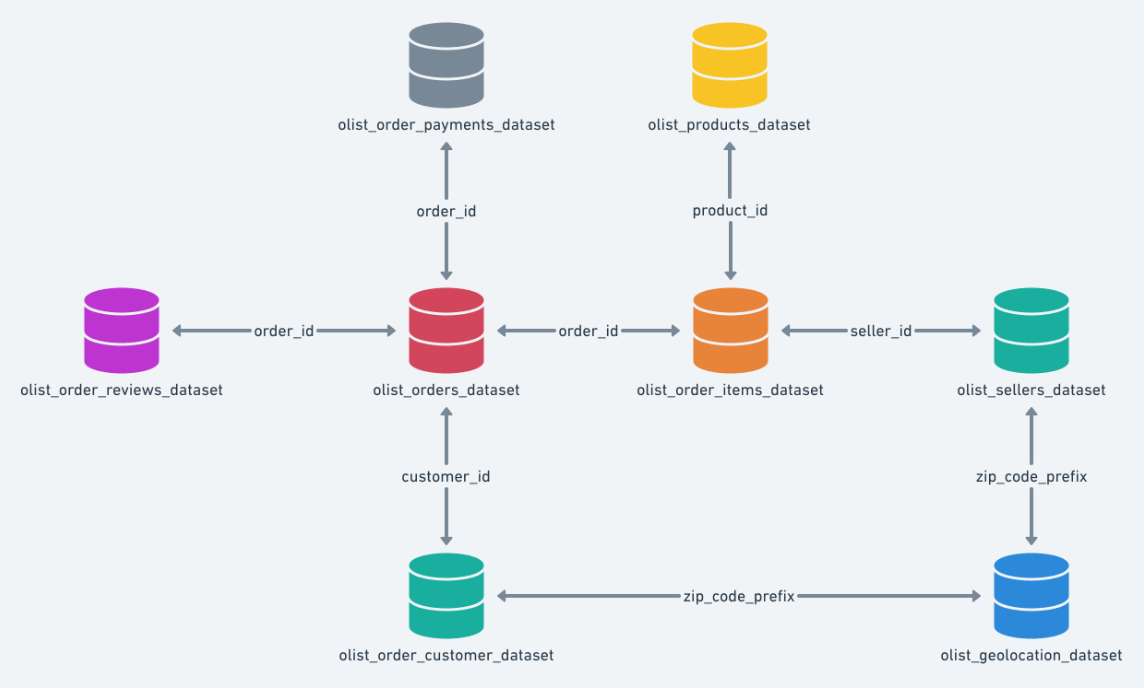

### **2.&nbsp;Chargement des données**

In [ ]:
from google.colab import drive
#drive.mount("/gdrive", force_remount=True)
#drive.flush_and_unmount()
drive.mount('/gdrive')
%cd /gdrive/MyDrive/Datasets
%ls

Mounted at /gdrive
/gdrive/MyDrive/Datasets
2016_Building_Energy_Benchmarking.csv  olist_order_payments_dataset.csv
clean-data.csv                         olist_order_reviews_dataset.csv
fr.openfoodfacts.org.products.csv      olist_orders_dataset.csv
house.csv                              olist_products_dataset.csv
olist_customers_dataset.csv            olist-rfm.csv
olist-customers-segmentation.csv       olist_sellers_dataset.csv
olist_geolocation_dataset.csv          product_category_name_translation.csv
olist_order_items_dataset.csv          sea-clean-data.csv


In [ ]:
# Librairies import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

**Les données clients**

In [ ]:
customers = pd.read_csv('olist_customers_dataset.csv', sep=',', low_memory=False)

In [ ]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [ ]:
customers.customer_unique_id.nunique()

96096

In [ ]:
customers.duplicated().sum()

0

In [ ]:
customers.duplicated(subset=["customer_unique_id"]).sum()

3345

Le dataset contient les information des clients et de leurs géolocalisation. Il est utilisé pour identifier de façon unique les clients dans le dataset des commandes. En plus du **customer_id** on a un **customer_unique_id**, cela s'explique par le fait qu'à chaque commande est assignée un id de client ce qui veut dire qu'un même client peut avoir différents id pour différentes commandes. Cet id unique permet d'identifier de manière unique les clients qui font de multiples achats.

**Les données de géolocalisation**

In [ ]:
geolocations = pd.read_csv('olist_geolocation_dataset.csv', sep=',', low_memory=False)

In [ ]:
geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [ ]:
geolocations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [ ]:
geolocations.duplicated(keep=False).sum()

390005

In [ ]:
bool_series_geolocations = geolocations.duplicated(keep=False)

In [ ]:
df_geolocations = geolocations[bool_series_geolocations]
df_geolocations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390005 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  390005 non-null  int64  
 1   geolocation_lat              390005 non-null  float64
 2   geolocation_lng              390005 non-null  float64
 3   geolocation_city             390005 non-null  object 
 4   geolocation_state            390005 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 17.9+ MB


In [ ]:
df_geolocations.sort_values(["geolocation_zip_code_prefix","geolocation_lat","geolocation_lng"], inplace = True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_geolocations.head(20)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
519,1001,-23.551337,-46.634027,sao paulo,SP
583,1001,-23.551337,-46.634027,sao paulo,SP
818,1001,-23.551337,-46.634027,sao paulo,SP
206,1001,-23.550498,-46.634338,sao paulo,SP
429,1001,-23.550498,-46.634338,sao paulo,SP
596,1001,-23.550498,-46.634338,sao paulo,SP
639,1001,-23.550498,-46.634338,sao paulo,SP
771,1001,-23.550498,-46.634338,sao paulo,SP
912,1001,-23.550498,-46.634338,sao paulo,SP
985,1001,-23.550498,-46.634338,sao paulo,SP


**Les commandes de produits**

In [ ]:
order_items = pd.read_csv('olist_order_items_dataset.csv', sep=',', low_memory=False)

In [ ]:
print(f'{order_items.order_id.nunique()}')

98666


In [ ]:
order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [ ]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [ ]:
order_items.duplicated(subset=["order_id"], keep='first').sum()

13984

In [ ]:
order_items.order_id.nunique()

98666

In [ ]:
bool_series_order_items = order_items.duplicated(subset=["order_id"], keep=False)

In [ ]:
df_order_items = order_items[bool_series_order_items]
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23787 entries, 13 to 112643
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   order_id             23787 non-null  object 
 1   order_item_id        23787 non-null  int64  
 2   product_id           23787 non-null  object 
 3   seller_id            23787 non-null  object 
 4   shipping_limit_date  23787 non-null  object 
 5   price                23787 non-null  float64
 6   freight_value        23787 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.5+ MB


In [ ]:
df_order_items.sort_values("order_id", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_order_items.head(20)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
32,00143d0f86d6fbd9f9b38ab440ac16f5,1,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
33,00143d0f86d6fbd9f9b38ab440ac16f5,2,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
34,00143d0f86d6fbd9f9b38ab440ac16f5,3,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,21.33,15.10
42,001ab0a7578dd66cd4b0a71f5b6e1e41,1,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
43,001ab0a7578dd66cd4b0a71f5b6e1e41,2,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
44,001ab0a7578dd66cd4b0a71f5b6e1e41,3,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,24.89,17.63
49,001d8f0e34a38c37f7dba2a37d4eba8b,2,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78
48,001d8f0e34a38c37f7dba2a37d4eba8b,1,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,18.99,7.78


Ce dataset contient toutes les informations sur les produits commandés

**Les options de paiement de commandes**

In [ ]:
order_payments = pd.read_csv('olist_order_payments_dataset.csv', sep=',', low_memory=False)

In [ ]:
order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [ ]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [ ]:
order_payments.order_id.nunique()

99440

In [ ]:
order_payments.duplicated(subset=["order_id"], keep='first').sum()

4446

In [ ]:
order_payments.order_id.nunique()

99440

In [ ]:
bool_series_order_payments = order_payments.duplicated(subset=["order_id"], keep=False)

In [ ]:
df_order_payments = order_payments[bool_series_order_payments]
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7407 entries, 25 to 103874
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   order_id              7407 non-null   object 
 1   payment_sequential    7407 non-null   int64  
 2   payment_type          7407 non-null   object 
 3   payment_installments  7407 non-null   int64  
 4   payment_value         7407 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 347.2+ KB


In [ ]:
df_order_payments.sort_values("order_id", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_order_payments.head(30)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
80856,0016dfedd97fc2950e388d2971d718c7,2,voucher,1,17.92
89575,0016dfedd97fc2950e388d2971d718c7,1,credit_card,5,52.63
20036,002f19a65a2ddd70a090297872e6d64e,1,voucher,1,44.11
98894,002f19a65a2ddd70a090297872e6d64e,2,voucher,1,33.18
30155,0071ee2429bc1efdc43aa3e073a5290e,2,voucher,1,92.44
10244,0071ee2429bc1efdc43aa3e073a5290e,1,voucher,1,100.00
16459,009ac365164f8e06f59d18a08045f6c4,2,voucher,1,4.50
15298,009ac365164f8e06f59d18a08045f6c4,6,voucher,1,4.17
32058,009ac365164f8e06f59d18a08045f6c4,4,voucher,1,5.45
285,009ac365164f8e06f59d18a08045f6c4,5,voucher,1,8.75


**Les reviews de commandes**

In [ ]:
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep=',', low_memory=False)

In [ ]:
order_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [ ]:
order_reviews.duplicated(subset=["order_id"], keep='first').sum()

551

In [ ]:
order_reviews.order_id.nunique()

98673

In [ ]:
bool_series_order_reviews = order_reviews.duplicated(subset=["order_id"], keep=False)

In [ ]:
df_order_reviews = order_reviews[bool_series_order_reviews]
df_order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098 entries, 30 to 99199
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                1098 non-null   object
 1   order_id                 1098 non-null   object
 2   review_score             1098 non-null   int64 
 3   review_comment_title     34 non-null     object
 4   review_comment_message   385 non-null    object
 5   review_creation_date     1098 non-null   object
 6   review_answer_timestamp  1098 non-null   object
dtypes: int64(1), object(6)
memory usage: 68.6+ KB


In [ ]:
df_order_reviews.sort_values("order_id", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df_order_reviews.head(30)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
25612,89a02c45c340aeeb1354a24e7d4b2c1e,0035246a40f520710769010f752e7507,5,NaN,NaN,2017-08-29 00:00:00,2017-08-30 01:59:12
22423,2a74b0559eb58fc1ff842ecc999594cb,0035246a40f520710769010f752e7507,5,NaN,Estou acostumada a comprar produtos pelo barat...,2017-08-25 00:00:00,2017-08-29 21:45:57
22779,ab30810c29da5da8045216f0f62652a2,013056cfe49763c6f66bda03396c5ee3,5,NaN,NaN,2018-02-22 00:00:00,2018-02-23 12:12:30
68633,73413b847f63e02bc752b364f6d05ee9,013056cfe49763c6f66bda03396c5ee3,4,NaN,NaN,2018-03-04 00:00:00,2018-03-05 17:02:00
854,830636803620cdf8b6ffaf1b2f6e92b2,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:06
83224,d8e8c42271c8fb67b9dad95d98c8ff80,0176a6846bcb3b0d3aa3116a9a768597,5,NaN,NaN,2017-12-30 00:00:00,2018-01-02 10:54:47
17582,017f0e1ea6386de662cbeba299c59ad1,02355020fd0a40a0d56df9f6ff060413,1,NaN,ja reclamei varias vezes e ate hoje não sei on...,2018-03-29 00:00:00,2018-03-30 03:16:19
89888,0c8e7347f1cdd2aede37371543e3d163,02355020fd0a40a0d56df9f6ff060413,3,NaN,UM DOS PRODUTOS (ENTREGA02) COMPRADOS NESTE PE...,2018-03-21 00:00:00,2018-03-22 01:32:08
55137,61fe4e7d1ae801bbe169eb67b86c6eda,029863af4b968de1e5d6a82782e662f5,4,NaN,NaN,2017-07-19 00:00:00,2017-07-20 12:06:11
37911,04d945e95c788a3aa1ffbee42105637b,029863af4b968de1e5d6a82782e662f5,5,NaN,NaN,2017-07-14 00:00:00,2017-07-17 13:58:06


Ce dataset contient toutes les informations concernant les reviews laissés par les clients après un achat. On constate des valeurs manquantes pour les colonnes **review_comment_title** et **review_comment_message**, tous les clients ne laissent pas nécessairement de commentaires sur les produits achetés.



**Les commandes clients**

In [ ]:
orders = pd.read_csv('olist_orders_dataset.csv', sep=',', low_memory=False)

In [ ]:
print(f'{orders[orders["order_status"] == "delivered"].order_id.nunique()}')

96478


In [ ]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [ ]:
orders.duplicated(subset=["order_id"]).sum()

0

In [ ]:
orders.order_id.nunique()

99441

C'est le dataset central dans la mesure où à partir des commandes clients on peut obtenir toutes les autres informations.

**Les données de produits**

In [ ]:
products = pd.read_csv('olist_products_dataset.csv', sep=',', low_memory=False)

In [ ]:
products.head()

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [ ]:
products.duplicated(subset=["product_id","product_category_name"]).sum()

0

Ce dataset contient toues les informations sur les produits vendus par Olist. Certaines informations descriptives des produits sont manquantes.

**Catégories de produits en anglais**

In [ ]:
categories_en = pd.read_csv('product_category_name_translation.csv', sep=',', low_memory=False)

In [ ]:
categories_en.head()

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
categories_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [ ]:
categories_en.duplicated().sum()

0

Ce dataset contient les noms des catégories de produits traduits en anglais

**Remarque**

Les vendeurs n'étant pas l'objet de cette analyse, nous allons ignorer le dataframe **sellers** pour le momemnt, nous le gardons au cas où on en aurait besoin par la suite.

### **3.&nbsp;Exploration des données**

### **3.1.&nbsp;Création de nouveaux dataset**

Nous allons à présent créer des dataset plus complets en réalisant des jointures

**Produits et catégories**

Nous allons joindre les données de produits et de catégories et supprimer certaines colonnes qui ne nous semblent pas pertinentes pour la suite de notrre analyse

In [ ]:
products_joint = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

del_features_list = ["product_category_name","product_weight_g",
                     "product_length_cm", "product_height_cm",
                     "product_width_cm"]
products_joint.drop(del_features_list, axis=1, inplace=True)
products_joint = products_joint.rename(columns={"product_category_name_english":
                                    "product_category_name"})


In [ ]:
products_joint.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,housewares


In [ ]:
products_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_name_lenght         32341 non-null  float64
 2   product_description_lenght  32341 non-null  float64
 3   product_photos_qty          32341 non-null  float64
 4   product_category_name       32328 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.5+ MB


Nous pouvons visualiser la répartition des diverses catégories de produits :

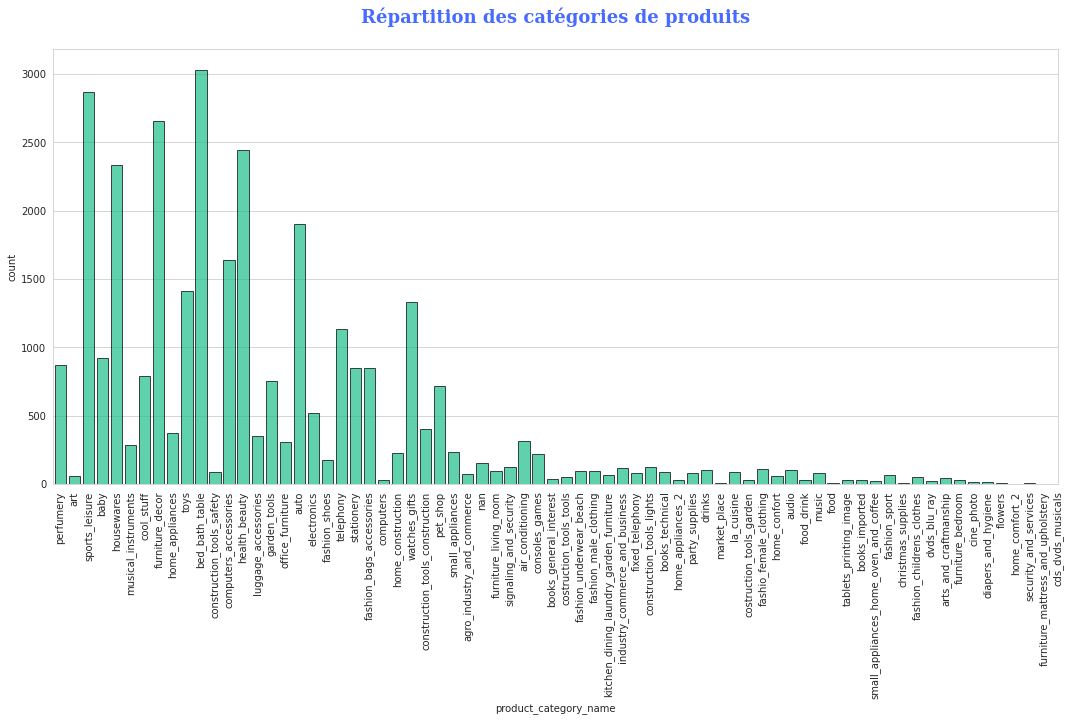

In [ ]:
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=products_joint, x="product_category_name",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.xticks(range(0, products_joint["product_category_name"].nunique()+1),
           products_joint["product_category_name"].unique(),
           rotation=90)
plt.title(f"Répartition des catégories de produits\n",
          fontdict=font_title)
plt.show()

**Commandes et produits commandés**


In [ ]:
order_items.shape

(112650, 7)

In [ ]:
print(f'{order_items.order_id.nunique()}')

98666


In [ ]:
orders.shape

(99441, 8)

In [ ]:
print(f'{orders.order_id.nunique()}')


99441


Nous allons regrouper les données de lignes de commandes, d'entêtes de commandes et de données clients dans un unique dataframe.

In [ ]:
order_items_joint = pd.merge(orders, order_items,
                       how="left",
                       on="order_id")

del_features_list = ["seller_id", "shipping_limit_date",
                     "order_delivered_carrier_date",
                     "order_estimated_delivery_date"]
order_items_joint.drop(del_features_list,
                 axis=1,
                 inplace=True)


In [ ]:
order_items_joint.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,1.0,87285b34884572647811a353c7ac498a,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,1.0,595fac2a385ac33a80bd5114aec74eb8,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,1.0,aa4383b373c6aca5d8797843e5594415,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,1.0,d0b61bfb1de832b15ba9d266ca96e5b0,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,1.0,65266b2da20d04dbe00c5c2d3bb7859e,19.90,8.72


In [ ]:
order_items_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113425 entries, 0 to 113424
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       113425 non-null  object 
 1   customer_id                    113425 non-null  object 
 2   order_status                   113425 non-null  object 
 3   order_purchase_timestamp       113425 non-null  object 
 4   order_approved_at              113264 non-null  object 
 5   order_delivered_customer_date  110196 non-null  object 
 6   order_item_id                  112650 non-null  float64
 7   product_id                     112650 non-null  object 
 8   price                          112650 non-null  float64
 9   freight_value                  112650 non-null  float64
dtypes: float64(3), object(7)
memory usage: 9.5+ MB


In [ ]:
order_items_joint.duplicated(subset=["order_id"], keep=False).sum()

23787

In [ ]:
order_items_joint.order_id.nunique()

99441

In [ ]:
bool_series = order_items_joint.duplicated(subset=["order_id"], keep=False)

In [ ]:
df = order_items_joint[bool_series]

In [ ]:
df.sort_values("order_id",inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [ ]:
df.head(20)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,price,freight_value
61487,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-26 13:55:22,1.0,368c6c730842d78016ad823897a372db,49.90,13.37
61488,0008288aa423d2a3f00fcb17cd7d8719,2355af7c75e7c98b43a87b2a7f210dc5,delivered,2018-02-13 22:10:21,2018-02-15 03:55:52,2018-02-26 13:55:22,2.0,368c6c730842d78016ad823897a372db,49.90,13.37
41331,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-27 18:43:56,2.0,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10
41332,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-27 18:43:56,3.0,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10
41330,00143d0f86d6fbd9f9b38ab440ac16f5,2e45292979b9b2700ea09560eeb0f803,delivered,2017-10-16 15:29:43,2017-10-16 16:07:52,2017-10-27 18:43:56,1.0,e95ee6822b66ac6058e2e4aff656071a,21.33,15.10
30744,001ab0a7578dd66cd4b0a71f5b6e1e41,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2018-01-17 20:43:29,3.0,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63
30743,001ab0a7578dd66cd4b0a71f5b6e1e41,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2018-01-17 20:43:29,2.0,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63
30742,001ab0a7578dd66cd4b0a71f5b6e1e41,8bb3bef4e75a95524235cdc11a7331af,delivered,2017-12-27 00:38:47,2017-12-28 02:33:42,2018-01-17 20:43:29,1.0,0b0172eb0fd18479d29c3bc122c058c2,24.89,17.63
48104,001d8f0e34a38c37f7dba2a37d4eba8b,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-26 13:14:50,1.0,e67307ff0f15ade43fcb6e670be7a74c,18.99,7.78
48105,001d8f0e34a38c37f7dba2a37d4eba8b,d987da9fb4086ab7c2c0f83963cd6722,delivered,2017-05-14 17:19:44,2017-05-14 17:35:11,2017-05-26 13:14:50,2.0,e67307ff0f15ade43fcb6e670be7a74c,18.99,7.78


Regardons les différents statuts de commande pour ne conserver que les commandes qui ont été livrées.

In [ ]:
order_items_joint.shape

(113425, 10)

In [ ]:
order_items_joint.order_id.nunique()

99441

In [ ]:
order_items_joint.groupby(by="order_status").count()["order_item_id"]

order_status
approved            3
canceled          542
created             0
delivered      110197
invoiced          359
processing        357
shipped          1185
unavailable         7
Name: order_item_id, dtype: int64

In [ ]:
order_items_joint = order_items_joint[order_items_joint["order_status"] == "delivered"]

In [ ]:
order_items_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 113424
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       110197 non-null  object 
 1   customer_id                    110197 non-null  object 
 2   order_status                   110197 non-null  object 
 3   order_purchase_timestamp       110197 non-null  object 
 4   order_approved_at              110182 non-null  object 
 5   order_delivered_customer_date  110189 non-null  object 
 6   order_item_id                  110197 non-null  float64
 7   product_id                     110197 non-null  object 
 8   price                          110197 non-null  float64
 9   freight_value                  110197 non-null  float64
dtypes: float64(3), object(7)
memory usage: 9.2+ MB


In [ ]:
order_items_joint.shape

(110197, 10)

In [ ]:
order_items_joint.order_id.nunique()

96478

Nous allons modifier les types de données en datetime pour les colonnes temporelles.

In [ ]:
# Modify object cols in timestamp format
datetime_cols = ["order_purchase_timestamp", "order_delivered_customer_date", "order_approved_at"]
for col in datetime_cols:
    order_items_joint[col] = order_items_joint[col].astype('datetime64[ns]')
order_items_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 113424
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_customer_date  110189 non-null  datetime64[ns]
 6   order_item_id                  110197 non-null  float64       
 7   product_id                     110197 non-null  object        
 8   price                          110197 non-null  float64       
 9   freight_value                  110197 non-null  float64       
dtypes: datetime64[ns](3), float64(3), object(4)
memory usage: 9.2+ MB


Nous pouvons également vérifier l'évolution du nombre de commandes passées par jour sur le site E-Commerce :

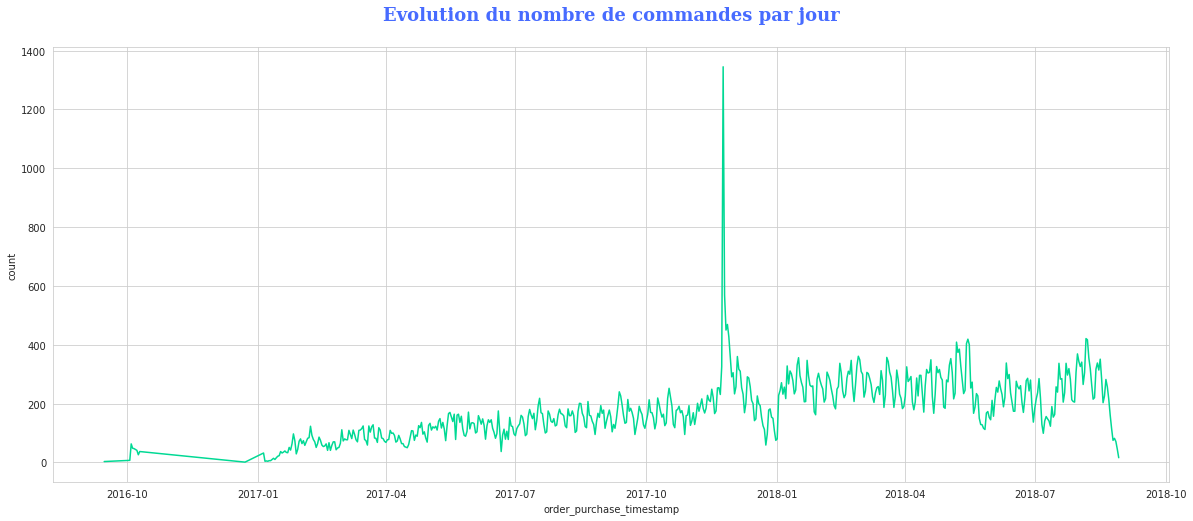

In [ ]:
orders_per_days = order_items_joint.groupby(order_items_joint["order_purchase_timestamp"].dt.date)\
                                    .count()["order_id"]
fig = plt.figure(figsize=(20, 8))
ax = orders_per_days.plot(color="#00d994")
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de commandes par jour\n",
          fontdict=font_title)
plt.savefig("../images/olist/evolution-cmmande-jour.png")
plt.show()

On constate un pic autour de Novembre / Décembre 2017 (ce qui peut s'expliquer car c'est la période des cadeaux de fin d'année). On constate également une période creuse quasiment sans commandes entre Octobre 2016 et Janvier 2017.

Nous pouvons également regarder la répartition du nombre de commandes par mois, jour de la semaine ou heure de la journée :

**Commandes par mois**

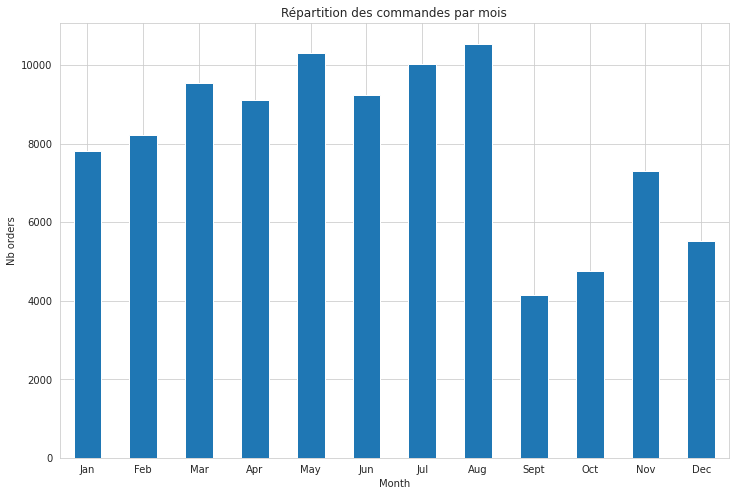

In [ ]:
order_items_joint.groupby(order_items_joint['order_purchase_timestamp'].dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par mois",
          ylabel="Nb orders",
          xlabel="Month",
          legend=False)
plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sept','Oct','Nov','Dec'],
           rotation='horizontal')
plt.show()

**Commande par jour de la semaine**

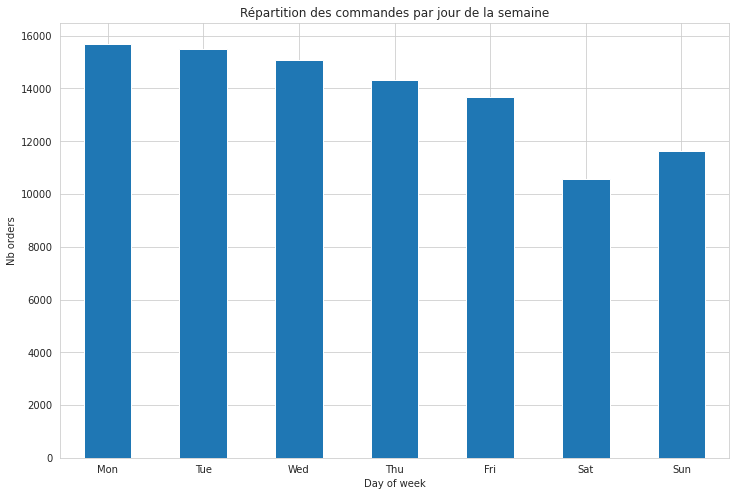

In [ ]:
order_items_joint.groupby(order_items_joint['order_purchase_timestamp'].dt.dayofweek)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par jour de la semaine",
          ylabel="Nb orders",
          xlabel="Day of week",
          legend=False)
plt.xticks(np.arange(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation='horizontal')
plt.show()

**Commandes par heure**

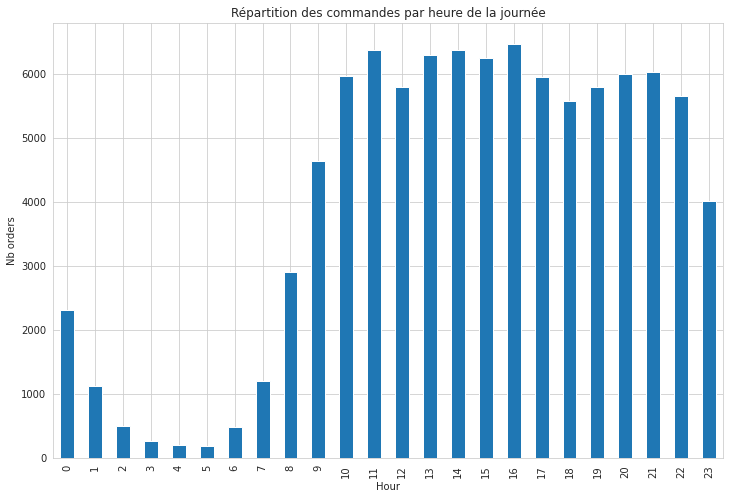

In [ ]:
order_items_joint.groupby(order_items_joint['order_purchase_timestamp'].dt.hour)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par heure de la journée",
          ylabel="Nb orders",
          xlabel="Hour",
          legend=False)
plt.show()

**Distribution du chiffre d'affaire sur les mois**

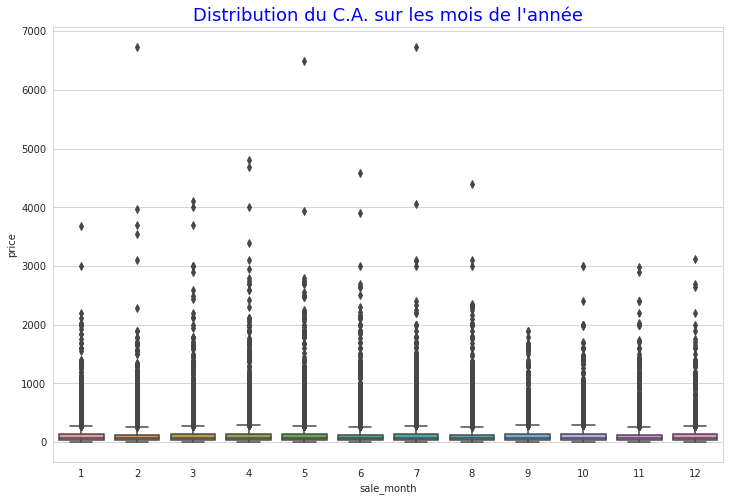

In [ ]:
order_items_joint["sale_month"] = order_items_joint['order_purchase_timestamp'].dt.month
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=order_items_joint, x="sale_month", y="price")
plt.title("Distribution du C.A. sur les mois de l'année", fontsize=18, color="b")
plt.show()

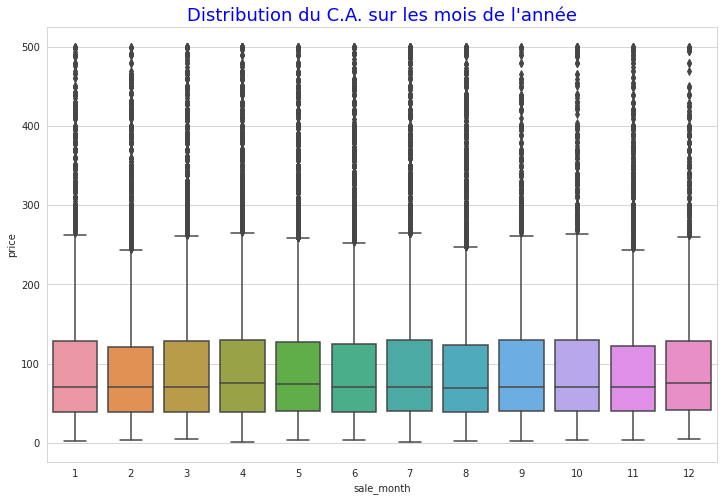

In [ ]:
order_items_joint["sale_month"] = order_items_joint['order_purchase_timestamp'].dt.month
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=order_items_joint[order_items_joint.price < 500], x="sale_month", y="price")
plt.title("Distribution du C.A. sur les mois de l'année", fontsize=18, color="b")
plt.show()

In [ ]:
order_items_joint.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 113424
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   customer_id                    110197 non-null  object        
 2   order_status                   110197 non-null  object        
 3   order_purchase_timestamp       110197 non-null  datetime64[ns]
 4   order_approved_at              110182 non-null  datetime64[ns]
 5   order_delivered_customer_date  110189 non-null  datetime64[ns]
 6   order_item_id                  110197 non-null  float64       
 7   product_id                     110197 non-null  object        
 8   price                          110197 non-null  float64       
 9   freight_value                  110197 non-null  float64       
 10  sale_month                     110197 non-null  int64         
dtype

Les médianes et variances restent très proche sur les différents mois de l'année.

**Les moyens de paiements**

Pour le dataset des paiements, vous allons créer de nouvelles variables à savoir :

* Le nombre de moyens de paiement différents utilisés sur la commande.
* Le nombre d'échéances totales de la commande.

In [ ]:
order_payments.shape

(103886, 5)

In [ ]:
order_payments.order_id.nunique()

99440

In [ ]:
order_items_joint.shape

(110197, 11)

In [ ]:
order_items_joint.order_id.nunique()

96478

In [ ]:
group_payments = order_payments.groupby(by="order_id").agg(
    {"payment_sequential": 'count',
     "payment_installments": 'sum',
     "payment_value":'sum'})


In [ ]:
group_payments.head()

,payment_sequential,payment_installments,payment_value
order_id,,,
00010242fe8c5a6d1ba2dd792cb16214,1,2,72.19
00018f77f2f0320c557190d7a144bdd3,1,3,259.83
000229ec398224ef6ca0657da4fc703e,1,5,216.87
00024acbcdf0a6daa1e931b038114c75,1,2,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,1,3,218.04


In [ ]:
group_payments.shape

(99440, 3)

In [ ]:
order_items_payments = pd.merge(group_payments, order_items_joint,
                       how="left",
                       on="order_id")

order_items_payments = order_items_payments.rename(columns={
    "payment_sequential": "nb_payment_sequential",
    "payment_installments": "sum_payment_installments",
    "payment_value": "sum_payment_value"})

In [ ]:
order_items_payments.head()

,order_id,nb_payment_sequential,sum_payment_installments,sum_payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,price,freight_value,sale_month
0,00010242fe8c5a6d1ba2dd792cb16214,1,2,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,9.0
1,00018f77f2f0320c557190d7a144bdd3,1,3,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,4.0
2,000229ec398224ef6ca0657da4fc703e,1,5,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,1.0
3,00024acbcdf0a6daa1e931b038114c75,1,2,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39,1.0,7634da152a4610f1595efa32f14722fc,12.99,12.79,8.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,3,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31,1.0,ac6c3623068f30de03045865e4e10089,199.90,18.14,2.0


In [ ]:
order_items_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113157 entries, 0 to 113156
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113157 non-null  object        
 1   nb_payment_sequential          113157 non-null  int64         
 2   sum_payment_installments       113157 non-null  int64         
 3   sum_payment_value              113157 non-null  float64       
 4   customer_id                    110194 non-null  object        
 5   order_status                   110194 non-null  object        
 6   order_purchase_timestamp       110194 non-null  datetime64[ns]
 7   order_approved_at              110179 non-null  datetime64[ns]
 8   order_delivered_customer_date  110186 non-null  datetime64[ns]
 9   order_item_id                  110194 non-null  float64       
 10  product_id                     110194 non-null  object        
 11  

In [ ]:
order_items_payments.shape

(113157, 14)

In [ ]:
order_items_payments.order_id.nunique()

99440

Nous allons également vérifier la répartition des moyens de paiement utilisés

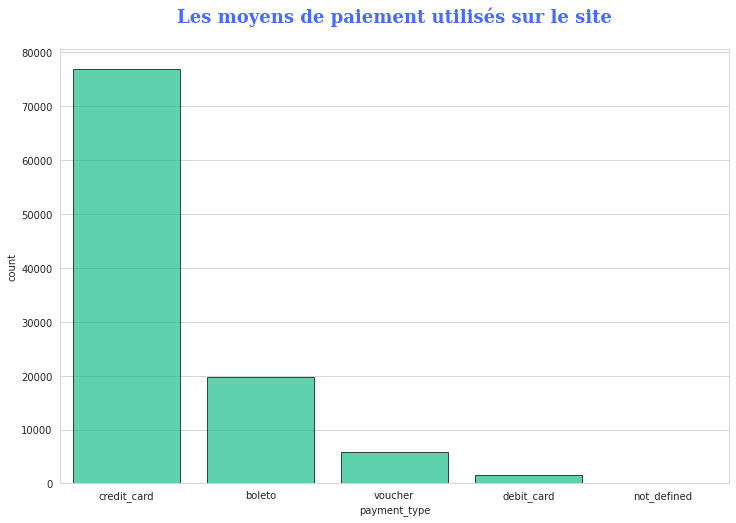

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(data=order_payments, x="payment_type",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.title(f"Les moyens de paiement utilisés sur le site\n",
          fontdict=font_title)
plt.savefig("../images/olist/paiment-utilisé.png")
plt.show()

**Les avis clients**

In [ ]:
order_reviews.shape

(99224, 7)

In [ ]:
order_reviews.order_id.nunique()

98673

In [ ]:
order_items_payments.shape

(113157, 14)

In [ ]:
order_items_payments.order_id.nunique()

99440

Pour les avis clients, nous allons également créer de nouvelles variables:
* une première variable qui indiquera seulement si oui ou non la commande a été notée (True or False)
* une seconde variable qui reprendra la note attribuée.

In [ ]:
group_reviews = order_reviews.groupby("order_id").agg({
    "review_id": "count",
    "review_score": "mean"})

In [ ]:
group_reviews.head()

,review_id,review_score
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,1,5.0
00018f77f2f0320c557190d7a144bdd3,1,4.0
000229ec398224ef6ca0657da4fc703e,1,5.0
00024acbcdf0a6daa1e931b038114c75,1,4.0
00042b26cf59d7ce69dfabb4e55b4fd9,1,5.0


In [ ]:
group_reviews.shape

(98673, 2)

In [ ]:
order_items_payments_reviews = pd.merge(order_items_payments, group_reviews,
                       how="left",
                       on="order_id")
order_items_payments_reviews = order_items_payments_reviews.rename(columns={
    "review_id": "is_reviewed"})

In [ ]:
order_items_payments_reviews.head()

,order_id,nb_payment_sequential,sum_payment_installments,sum_payment_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_item_id,product_id,price,freight_value,sale_month,is_reviewed,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,1,2,72.19,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,1.0,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,9.0,1.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,1,3,259.83,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-12 16:04:24,1.0,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,4.0,1.0,4.0
2,000229ec398224ef6ca0657da4fc703e,1,5,216.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-22 13:19:16,1.0,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,1.0,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,2,25.78,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-14 13:32:39,1.0,7634da152a4610f1595efa32f14722fc,12.99,12.79,8.0,1.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,3,218.04,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-03-01 16:42:31,1.0,ac6c3623068f30de03045865e4e10089,199.90,18.14,2.0,1.0,5.0


In [ ]:
order_items_payments_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113157 entries, 0 to 113156
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       113157 non-null  object        
 1   nb_payment_sequential          113157 non-null  int64         
 2   sum_payment_installments       113157 non-null  int64         
 3   sum_payment_value              113157 non-null  float64       
 4   customer_id                    110194 non-null  object        
 5   order_status                   110194 non-null  object        
 6   order_purchase_timestamp       110194 non-null  datetime64[ns]
 7   order_approved_at              110179 non-null  datetime64[ns]
 8   order_delivered_customer_date  110186 non-null  datetime64[ns]
 9   order_item_id                  110194 non-null  float64       
 10  product_id                     110194 non-null  object        
 11  

In [ ]:
order_items_payments_reviews.shape

(113157, 16)

In [ ]:
order_items_payments_reviews.order_id.nunique()

99440

In [ ]:
order_items_payments_reviews["is_reviewed"] = np.where(order_items_payments_reviews["is_reviewed"] == 1,
                                      True, False)

In [ ]:
order_items_payments_reviews.shape

(113157, 16)

In [ ]:
order_items_payments_reviews.order_id.nunique()

99440

Nous pouvons à présent projeter la répartion des notes attribuées aux commandes du site :

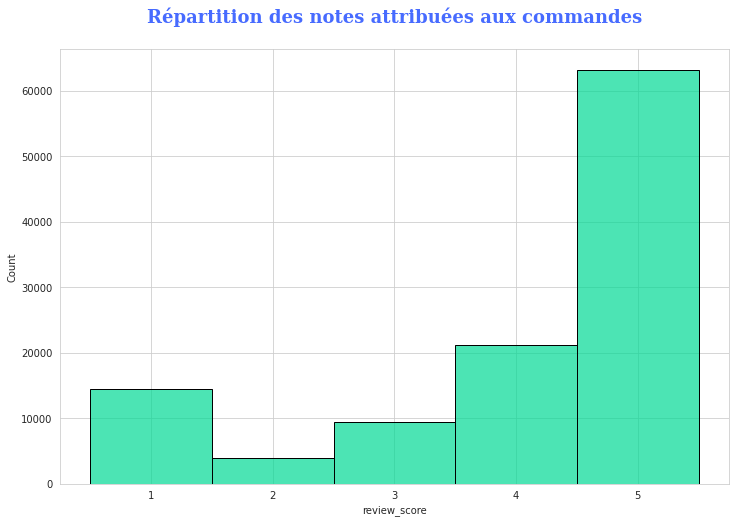

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=order_items_payments_reviews, x="review_score",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.title(f"Répartition des notes attribuées aux commandes\n",
          fontdict=font_title)
plt.savefig("../images/olist/répartition-notes-attribuées.png")
plt.show()

### **3.2.&nbsp;Création de dataset global**

**Les données clients**

In [ ]:
order_items_payments_reviews.shape

(113157, 16)

In [ ]:
order_items_payments_reviews.order_id.nunique()

99440

In [ ]:
order_items_payments_reviews.customer_id.nunique()

96477

In [ ]:
customers.shape

(99441, 5)

In [ ]:
customers.customer_id.nunique()

99441

In [ ]:
customers.customer_unique_id.nunique()

96096

Nous réalisons à présent les jointures sur les fichiers client

In [ ]:
order_items_payments_reviews_customers = pd.merge(customers, order_items_payments_reviews,
                       how="left",
                       on="customer_id")

In [ ]:
order_items_payments_reviews_customers.shape

(113158, 20)

In [ ]:
order_items_payments_reviews_customers.customer_unique_id.nunique()

96096

In [ ]:
order_items_payments_reviews_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113158 entries, 0 to 113157
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113158 non-null  object        
 1   customer_unique_id             113158 non-null  object        
 2   customer_zip_code_prefix       113158 non-null  int64         
 3   customer_city                  113158 non-null  object        
 4   customer_state                 113158 non-null  object        
 5   order_id                       110194 non-null  object        
 6   nb_payment_sequential          110194 non-null  float64       
 7   sum_payment_installments       110194 non-null  float64       
 8   sum_payment_value              110194 non-null  float64       
 9   order_status                   110194 non-null  object        
 10  order_purchase_timestamp       110194 non-null  datetime64[ns]
 11  

**Dataset global**

On crée le dataset global

In [ ]:
products.shape

(32951, 9)

In [ ]:
products.product_id.nunique()

32951

In [ ]:
order_items_payments_reviews_customers.product_id.nunique()

32216

In [ ]:
data_global = pd.merge(order_items_payments_reviews_customers, products,
               how="left",
               on="product_id")

In [ ]:
data_global.shape

(113158, 28)

In [ ]:
data_global.customer_unique_id.nunique()

96096

In [ ]:
data_global.product_id.nunique()

32216

In [ ]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113158 entries, 0 to 113157
Data columns (total 28 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113158 non-null  object        
 1   customer_unique_id             113158 non-null  object        
 2   customer_zip_code_prefix       113158 non-null  int64         
 3   customer_city                  113158 non-null  object        
 4   customer_state                 113158 non-null  object        
 5   order_id                       110194 non-null  object        
 6   nb_payment_sequential          110194 non-null  float64       
 7   sum_payment_installments       110194 non-null  float64       
 8   sum_payment_value              110194 non-null  float64       
 9   order_status                   110194 non-null  object        
 10  order_purchase_timestamp       110194 non-null  datetime64[ns]
 11  

### **3.3.&nbsp;Feature engineering**

Commençons par créer une variable contenant le délai le livraison de chaque commande

In [ ]:
data_global["delivery_delta_days"] = (data_global.order_delivered_customer_date
                               - data_global.order_purchase_timestamp)\
                              .dt.round('1d').dt.days
data_global.drop("order_delivered_customer_date", axis=1, inplace=True)

In [ ]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113158 entries, 0 to 113157
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   customer_id                 113158 non-null  object        
 1   customer_unique_id          113158 non-null  object        
 2   customer_zip_code_prefix    113158 non-null  int64         
 3   customer_city               113158 non-null  object        
 4   customer_state              113158 non-null  object        
 5   order_id                    110194 non-null  object        
 6   nb_payment_sequential       110194 non-null  float64       
 7   sum_payment_installments    110194 non-null  float64       
 8   sum_payment_value           110194 non-null  float64       
 9   order_status                110194 non-null  object        
 10  order_purchase_timestamp    110194 non-null  datetime64[ns]
 11  order_approved_at           110179 non-

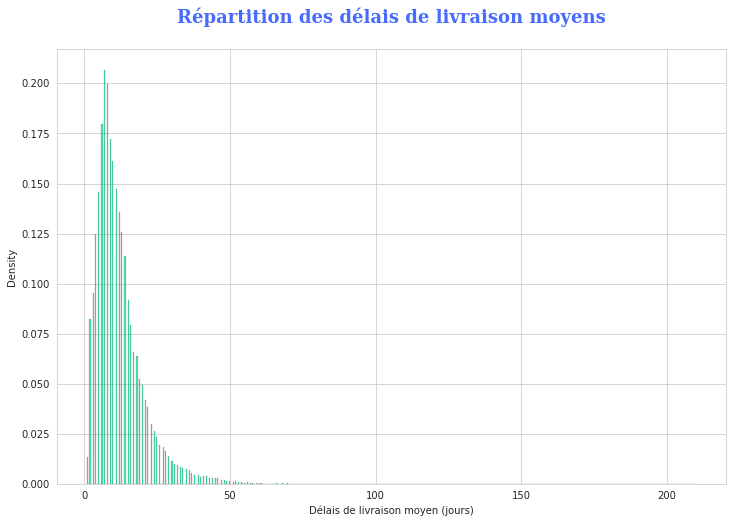

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=data_global, x="delivery_delta_days",
             stat="density",
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Délais de livraison moyen (jours)")
plt.title(f"Répartition des délais de livraison moyens\n",
          fontdict=font_title)
plt.show()


le jeu de données compte plus de 70 catégories différentes (ce qui peut poser problème pour un encodage lors des preprocessing). Nous allons donc devoir regrouper plusieurs de ces catégorie dans une catégorie de niveau supérieur.

Pour cela, nous allons nous baser sur les catégories principales des sites de vente en ligne en 2017, disponibles sur le site [http://statista.com](https://www.statista.com/statistics/311406/us-online-shopping-categories-gender/) :
* Fashion, clothing and accessories
* Health and Beauty
* Toys and baby equipment
* Books, CDs and other physical media
* Groceries, food and drink
* Technology (including phones and computers)
* Home and furniture
* Flowers and gifts
* Other
* et nous ajoutons la catégorie sport



In [ ]:
data_global['product_category'] = np.where((data_global['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((data_global['product_category_name'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((data_global['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((data_global['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((data_global['product_category_name'].str.contains("grocer|food|drink")==True),
                                     'groceries_food_drink',
                           np.where((data_global['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True),
                                     'technology',
                           np.where((data_global['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True),
                                     'home_furniture',
                           np.where((data_global['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((data_global['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))

In [ ]:
# drop product_category_name column
data_global.drop("product_category_name", axis=1, inplace=True)

In [ ]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113158 entries, 0 to 113157
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   customer_id                 113158 non-null  object        
 1   customer_unique_id          113158 non-null  object        
 2   customer_zip_code_prefix    113158 non-null  int64         
 3   customer_city               113158 non-null  object        
 4   customer_state              113158 non-null  object        
 5   order_id                    110194 non-null  object        
 6   nb_payment_sequential       110194 non-null  float64       
 7   sum_payment_installments    110194 non-null  float64       
 8   sum_payment_value           110194 non-null  float64       
 9   order_status                110194 non-null  object        
 10  order_purchase_timestamp    110194 non-null  datetime64[ns]
 11  order_approved_at           110179 non-

In [ ]:
data_global.customer_unique_id.nunique()

96096

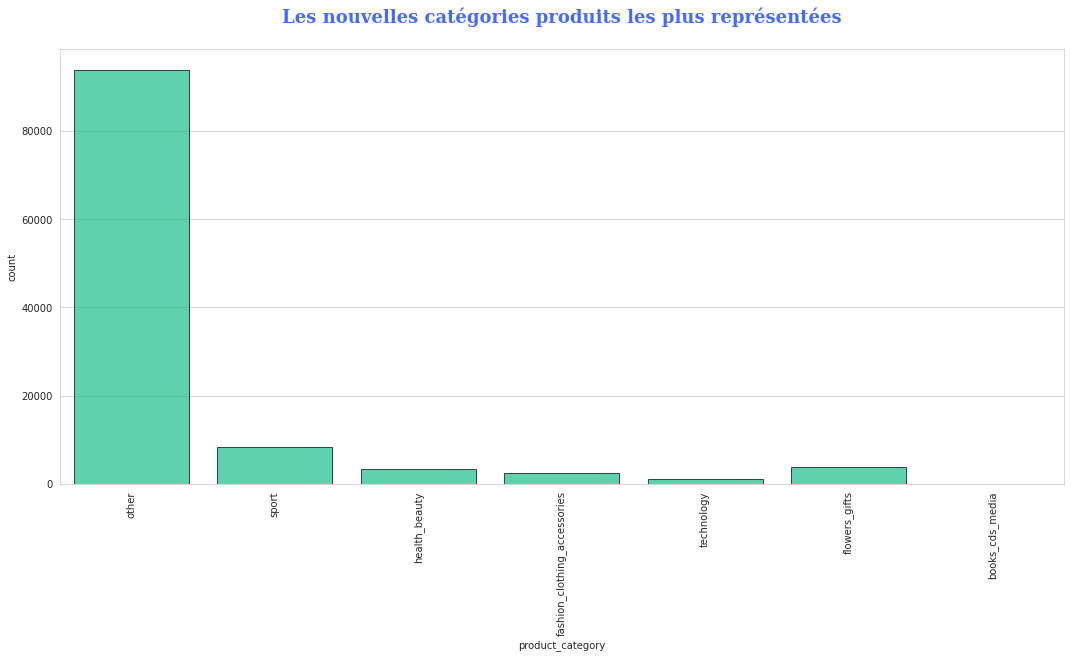

In [ ]:
# Plot categories count in dataset
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data_global, x="product_category",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.xticks(range(0, data_global["product_category"].nunique()),
           data_global["product_category"].unique(),
           rotation=90)
plt.title(f"Les nouvelles catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

Nous allons regarder la répartition du nombre de commandes moyen par client :

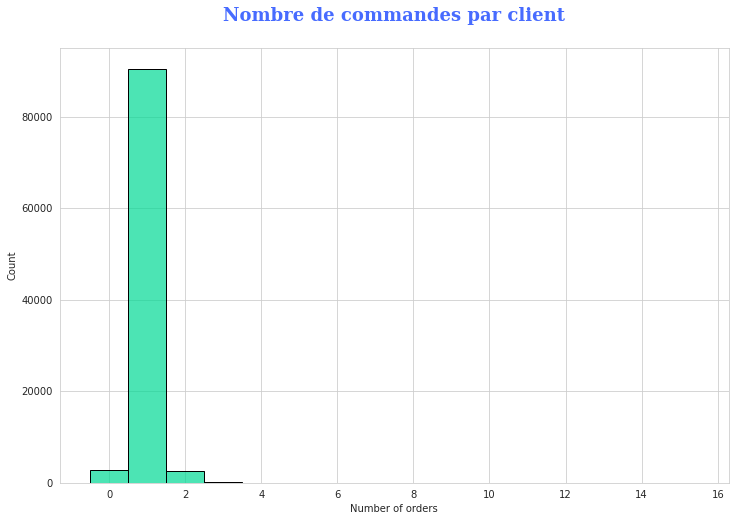

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data_global.groupby("customer_unique_id").agg({"order_id": "nunique"}),
             x="order_id",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Number of orders")
plt.title(f"Nombre de commandes par client\n",
          fontdict=font_title)
plt.savefig("../images/olist/commandes-par-client.png")
plt.show()

La majeure partie des clients n'ont passé qu'une seule commande. Il sera donc compliqué d'établir un classement de leur catégorie produit préférée. Nous allons donc créer **une variable qui présentera par catégorie produit, le nombre de produits achetés sur les commandes passées**.
Ensuite, nous calculerons **le ratio du nombre de produits par catégorie sur le nombre de produits total acheté par le client**.

In [ ]:
categories_customers = data_global.groupby(["customer_unique_id", "product_category"])\
                        .agg({"order_item_id": "count"}).unstack()
categories_customers.columns = categories_customers.columns.droplevel(0)
categories_customers.fillna(0, inplace=True)
categories_customers["total_items"] = categories_customers.sum(axis=1)

# ratio of total items
for col in categories_customers.columns:
    if (col != "total_items"):
        categories_customers[col] = (categories_customers[col]/categories_customers["total_items"])

categories_customers.reset_index(inplace=True)
categories_customers.head(3)

product_category,customer_unique_id,books_cds_media,fashion_clothing_accessories,flowers_gifts,health_beauty,other,sport,technology,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
categories_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            96096 non-null  object 
 1   books_cds_media               93357 non-null  float64
 2   fashion_clothing_accessories  93357 non-null  float64
 3   flowers_gifts                 93357 non-null  float64
 4   health_beauty                 93357 non-null  float64
 5   other                         93357 non-null  float64
 6   sport                         93357 non-null  float64
 7   technology                    93357 non-null  float64
 8   total_items                   96096 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.6+ MB


Nous allons ensuite calculer le **nombre moyen d'articles par commande pour chaque client**

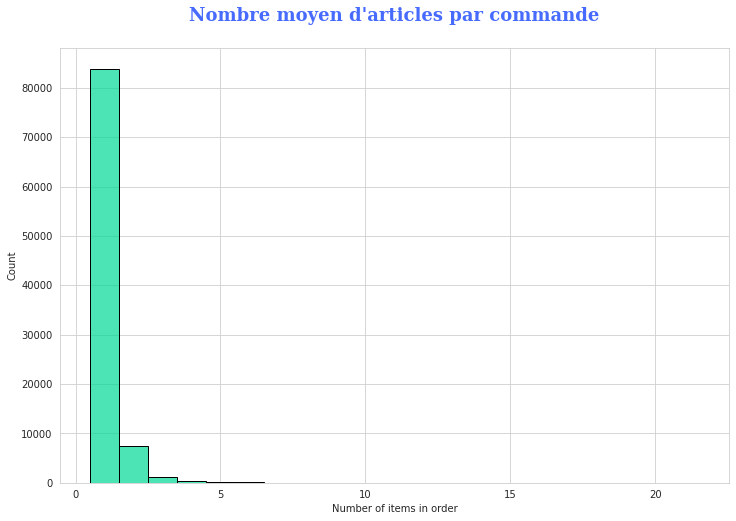

In [ ]:
products_per_order = data_global.groupby(["customer_unique_id", "order_id"])\
                        .agg({"order_item_id": "count"})
products_per_order = products_per_order.groupby("customer_unique_id")\
                        .agg({"order_item_id": "mean"})

# Plot density of number items in order
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = products_per_order,
             x="order_item_id",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Number of items in order")
plt.title(f"Nombre moyen d'articles par commande\n",
          fontdict=font_title)
plt.savefig("../images/olist/items-par-commande.png")
plt.show()

In [ ]:
products_per_order.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93357 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   order_item_id  93357 non-null  float64
dtypes: float64(1)
memory usage: 1.4+ MB


nous allons calculer le **nombre de jours écoulés entre la première et la dernière commande**

In [ ]:
recurencies = data_global.groupby("customer_unique_id")\
                .agg({"order_purchase_timestamp": ["min","max"]})
recurencies.columns = recurencies.columns.droplevel(0)

# Max date in dataset
max_date = data_global["order_purchase_timestamp"].max()

# Delay from the last order
recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0]
                                    else (max_date - y[0]).round('1d').days
                                    for x,y in recurencies.iterrows()]
recurencies.drop(["min", "max"], axis=1, inplace=True)
recurencies.head(3)

,order_total_delay
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,111.0
0000b849f77a49e4a4ce2b2a4ca5be3f,114.0
0000f46a3911fa3c0805444483337064,537.0


In [ ]:
recurencies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 96096 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_total_delay  93357 non-null  float64
dtypes: float64(1)
memory usage: 1.5+ MB


**Création du score RFM**

**R = Récence**  
Nombre de jours depuis le dernier achat


In [ ]:
max_date = data_global.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
max_date = max_date.rename({'order_purchase_timestamp':'most_recent'},axis = 1)
max_date.head()

,customer_unique_id,most_recent
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42


In [ ]:
max_date.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_unique_id  96096 non-null  object        
 1   most_recent         93357 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ MB


In [ ]:
max_date['r_score'] = (max_date['most_recent'].max() - max_date['most_recent']).dt.days
max_date.head()

,customer_unique_id,most_recent,r_score
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,111.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,114.0
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,536.0
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,320.0
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,287.0


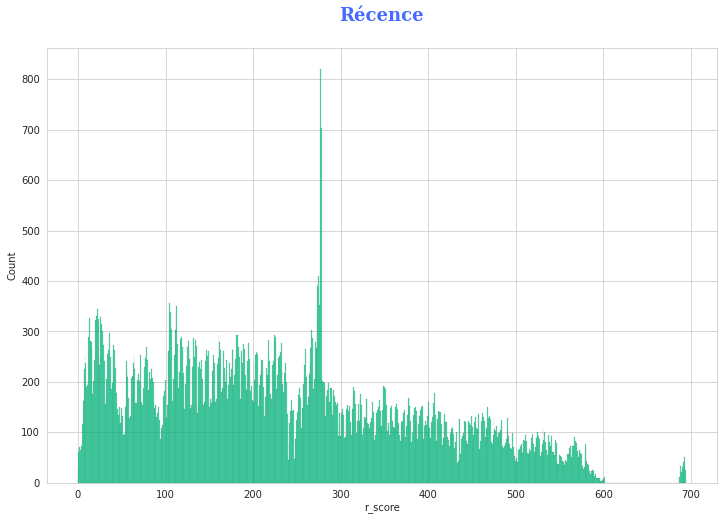

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = max_date,
             x="r_score",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("r_score")
plt.title(f"Récence\n",
          fontdict=font_title)
plt.savefig("../images/olist/récence.png")
plt.show()

**F = Fréquence**  
Nombre de fois que le client a fait un achat

In [ ]:
n_transaction = data_global.groupby('customer_unique_id')['order_id'].count().reset_index()
n_transaction = n_transaction.rename({'order_id':'f_score'},axis = 1)
n_transaction.head()

,customer_unique_id,f_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


In [ ]:
n_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   customer_unique_id  96096 non-null  object
 1   f_score             96096 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


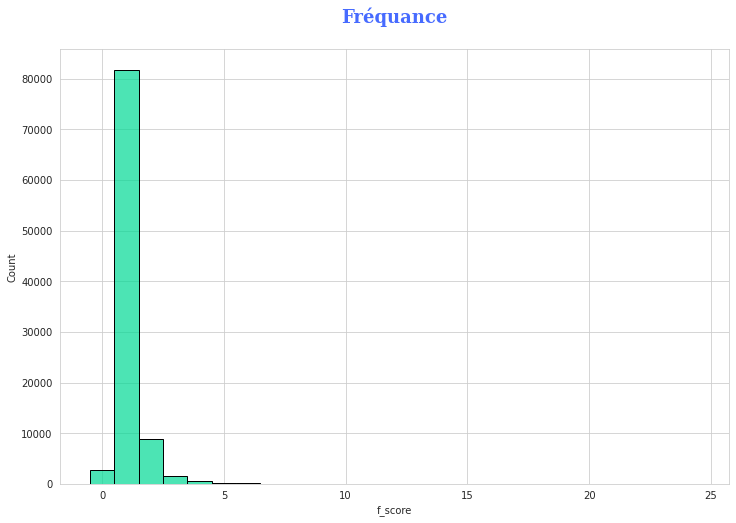

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = n_transaction,
             x="f_score",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("f_score")
plt.title(f"Fréquance\n",
          fontdict=font_title)
plt.savefig("../images/olist/fréquance.png")
plt.show()

**M = Monnaie**  
Valeur moyenne des achats fait par un client

In [ ]:
avg_purchase = data_global.groupby('customer_unique_id')['sum_payment_value'].mean().reset_index()
avg_purchase = avg_purchase.rename({'sum_payment_value':'m_score'},axis = 1)
avg_purchase.head()

,customer_unique_id,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [ ]:
avg_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96096 entries, 0 to 96095
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   m_score             93357 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.5+ MB


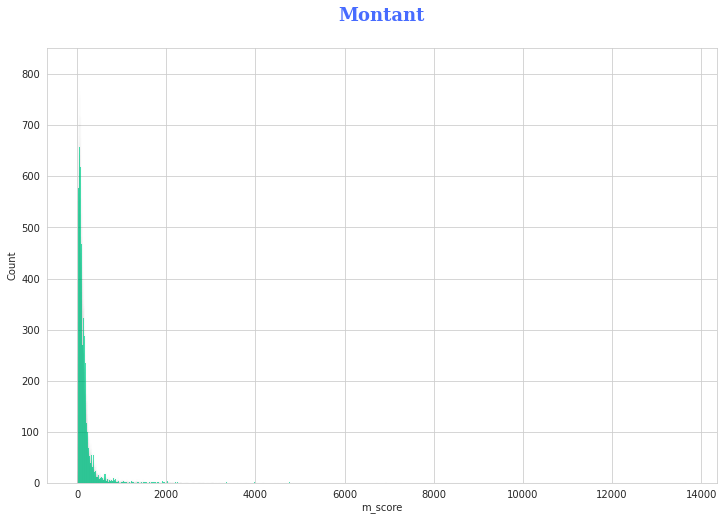

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = avg_purchase,
             x="m_score",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("m_score")
plt.title(f"Montant\n",
          fontdict=font_title)
plt.savefig("../images/olist/montant.png")
plt.show()

In [ ]:
df_rf = max_date.merge(n_transaction, how = 'left', on = 'customer_unique_id')
df_rfm = df_rf.merge(avg_purchase, how = 'left', on = 'customer_unique_id')
df_rfm = df_rfm[['customer_unique_id','r_score','f_score','m_score']]
df_rfm.head()

,customer_unique_id,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,111.0,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114.0,1,27.19
2,0000f46a3911fa3c0805444483337064,536.0,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,320.0,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,287.0,1,196.89


In [ ]:
df_rfm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  96096 non-null  object 
 1   r_score             93357 non-null  float64
 2   f_score             96096 non-null  int64  
 3   m_score             93357 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 3.7+ MB


Export du dataset rfm

In [ ]:
df_rfm.to_csv("olist-rfm.csv")

**Création du dataset centré client**

In [ ]:
data_global.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,nb_payment_sequential,sum_payment_installments,sum_payment_value,order_status,...,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,delivery_delta_days,product_category
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,1.0,2.0,146.87,delivered,...,4.0,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,9.0,other
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,1.0,8.0,335.48,delivered,...,5.0,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,17.0,other
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,1.0,7.0,157.73,delivered,...,5.0,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,26.0,other
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,1.0,1.0,173.30,delivered,...,5.0,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,15.0,other
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,1.0,8.0,252.25,delivered,...,5.0,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,11.0,other


In [ ]:
data_global.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113158 entries, 0 to 113157
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   customer_id                 113158 non-null  object        
 1   customer_unique_id          113158 non-null  object        
 2   customer_zip_code_prefix    113158 non-null  int64         
 3   customer_city               113158 non-null  object        
 4   customer_state              113158 non-null  object        
 5   order_id                    110194 non-null  object        
 6   nb_payment_sequential       110194 non-null  float64       
 7   sum_payment_installments    110194 non-null  float64       
 8   sum_payment_value           110194 non-null  float64       
 9   order_status                110194 non-null  object        
 10  order_purchase_timestamp    110194 non-null  datetime64[ns]
 11  order_approved_at           110179 non-

In [ ]:
data = data_global.groupby("customer_unique_id")\
            .agg({"order_id": "nunique",
                  "price": "sum",
                  "freight_value": "sum",
                  "nb_payment_sequential": "mean",
                  "sum_payment_installments": "mean",
                  "review_score": "mean",
                  "delivery_delta_days": "mean",
                  "sale_month": lambda x:x.value_counts()})
# Rename columns
data = data.rename(columns={"order_id": "nb_orders",
                            "price": "total_spend",
                            "freight_value": "total_freight",
                            "nb_payment_sequential": "mean_payment_sequential",
                            "sum_payment_installments": "mean_payment_installments",
                            "review_score": "mean_review_score",
                            "delivery_delta_days": "mean_delivery_days",
                            "sale_month": "favorite_sale_month"})
# Merge with other calculated features
data = pd.merge(data, categories_customers,
                how="left",
                on="customer_unique_id")

data = pd.merge(data, products_per_order,
                how="left",
                on="customer_unique_id")\
        .rename(columns={"order_item_id": "mean_nb_items"})

data = pd.merge(data, recurencies,
                how="left",
                on="customer_unique_id")



In [ ]:
''' data.astype({'favorite_sale_month':'int64'}).dtypes '''

" data.astype({'favorite_sale_month':'int64'}).dtypes "

In [ ]:
data = data.merge(df_rfm, how = 'left', on = 'customer_unique_id')
data.head()

,customer_unique_id,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,...,health_beauty,other,sport,technology,total_items,mean_nb_items,order_total_delay,r_score,f_score,m_score
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,1.0,8.0,5.0,6.0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,111.0,111.0,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,1.0,1.0,4.0,3.0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,114.0,114.0,1,27.19
2,0000f46a3911fa3c0805444483337064,1,69.00,17.22,1.0,8.0,3.0,26.0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,537.0,536.0,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,1.0,4.0,4.0,20.0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,321.0,320.0,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,1.0,6.0,5.0,13.0,1,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,288.0,287.0,1,196.89


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            96096 non-null  object 
 1   nb_orders                     96096 non-null  int64  
 2   total_spend                   96096 non-null  float64
 3   total_freight                 96096 non-null  float64
 4   mean_payment_sequential       93357 non-null  float64
 5   mean_payment_installments     93357 non-null  float64
 6   mean_review_score             92754 non-null  float64
 7   mean_delivery_days            93349 non-null  float64
 8   favorite_sale_month           96096 non-null  object 
 9   books_cds_media               93357 non-null  float64
 10  fashion_clothing_accessories  93357 non-null  float64
 11  flowers_gifts                 93357 non-null  float64
 12  health_beauty                 93357 non-null  float64
 13  o

nous allons ramener le délais des commandes client en fonction du nombre de commandes pour obtenir le délai moyen entre plusieurs achats :

In [ ]:
data["order_total_delay"] = data["order_total_delay"] / data["nb_orders"]
data = data.rename(columns={"order_total_delay": "order_mean_delay"})

Nous allons calculer quelques dernières variables:

* Le ratio fret / total commande
* le prix moyen par commande

In [ ]:
data["freight_ratio"] = round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2)
data["mean_price_order"] = round(data["total_spend"] / data["nb_orders"],2)
data["total_spend"] = (data["total_spend"] + data["total_freight"])
data.drop("total_freight", axis=1, inplace=True)

Nous allons rajouter les données de géolocalisation

In [ ]:
customers_info = customers.groupby("customer_unique_id").agg(lambda x:x.value_counts().index[0])
data = pd.merge(data, customers_info,
                how="left",
                on="customer_unique_id")

**Exploration du dataset**

In [ ]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            96096 non-null  object 
 1   nb_orders                     96096 non-null  int64  
 2   total_spend                   96096 non-null  float64
 3   mean_payment_sequential       93357 non-null  float64
 4   mean_payment_installments     93357 non-null  float64
 5   mean_review_score             92754 non-null  float64
 6   mean_delivery_days            93349 non-null  float64
 7   favorite_sale_month           96096 non-null  object 
 8   books_cds_media               93357 non-null  float64
 9   fashion_clothing_accessories  93357 non-null  float64
 10  flowers_gifts                 93357 non-null  float64
 11  health_beauty                 93357 non-null  float64
 12  other                         93357 non-null  float64
 13  s

 Certaines variables contiennent des valeurs nulles. Nous allons les compléter par les valeurs les plus fréquentes :

In [ ]:
# Find features to fill and fillna with mode
features_to_fill = data.isnull().sum()
features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

for f in features_to_fill:
    data[f] = data[f].fillna(data[f].mode()[0])
    print(f, data[f].mode()[0])

mean_payment_sequential 1.0
mean_payment_installments 1.0
mean_review_score 5.0
mean_delivery_days 7.0
books_cds_media 0.0
fashion_clothing_accessories 0.0
flowers_gifts 0.0
health_beauty 0.0
other 1.0
sport 0.0
technology 0.0
mean_nb_items 1.0
order_mean_delay 278.0
r_score 277.0
m_score 77.57
freight_ratio 0.13
mean_price_order 59.9


In [ ]:
data.describe()


,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,books_cds_media,fashion_clothing_accessories,flowers_gifts,health_beauty,...,technology,total_items,mean_nb_items,order_mean_delay,r_score,f_score,m_score,freight_ratio,mean_price_order,customer_zip_code_prefix
count,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,...,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000,96096.000000
mean,1.003965,160.460688,1.042622,2.909937,4.182815,12.366427,0.000681,0.022833,0.035998,0.031047,...,0.011123,1.146707,1.135534,233.793836,238.078588,1.146707,158.087768,0.205915,135.296240,35185.678020
std,0.268418,224.732003,0.359279,2.698617,1.267658,9.457314,0.025950,0.148047,0.185208,0.172524,...,0.104383,0.642671,0.519995,152.155798,150.541727,0.642671,217.010401,0.123783,207.251696,29801.656442
min,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,9.590000,0.000000,0.850000,1003.000000
25%,1.000000,59.420000,1.000000,1.000000,4.000000,7.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,111.000000,116.000000,1.000000,63.270000,0.120000,47.990000,11390.000000
50%,1.000000,104.900000,1.000000,2.000000,5.000000,10.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,219.000000,224.000000,1.000000,102.650000,0.180000,83.385000,24440.000000
75%,1.000000,178.490000,1.000000,4.000000,5.000000,15.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,336.000000,341.000000,1.000000,173.840000,0.270000,149.000000,59035.500000
max,15.000000,13664.080000,26.000000,26.000000,5.000000,210.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,24.000000,21.000000,695.000000,694.000000,24.000000,13664.080000,0.960000,13440.000000,99990.000000


On peut voir également dans cette description qu'une commande est chiffrée à plus de 13 000 dollars. Nous allons vérifier cette commande atypique :

In [ ]:
data[data["mean_price_order"] == data["mean_price_order"].max()]


,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,order_mean_delay,r_score,f_score,m_score,freight_ratio,mean_price_order,customer_id,customer_zip_code_prefix,customer_city,customer_state
3826,0a0a92112bd4c708ca5fde585afaa872,1,13664.08,1.0,1.0,1.0,18.0,8,0.0,0.0,...,334.0,333.0,8,13664.08,0.02,13440.0,1617b1357756262bfa56ab541c47bc16,20080,rio de janeiro,RJ


Cette commande contient 8 articles technologiques pour un montant de 13 000 dollars. C'est atypique certes, mais ce n'est pas pour autant une donnée abérrante. Nous la conservons donc.

Regardons la dispersion des montants moyen de commandes en fonction du nombre d'articles pour tenter de repérer d'autres anomalies :

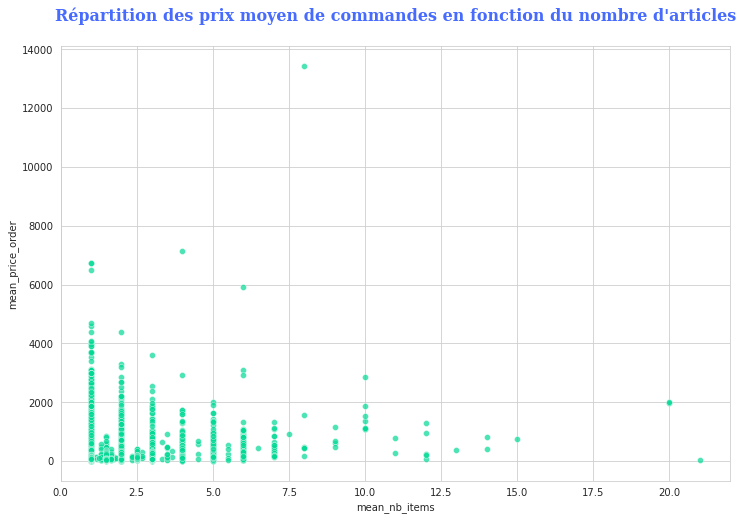

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, y="mean_price_order", x="mean_nb_items",
                color="#00d994", alpha=0.7)
plt.title(f"Répartition des prix moyen de commandes en fonction du nombre d'articles\n",
          fontdict=font_title, fontsize=16)
plt.show()

Une commande de plus de 20 articles est affichée pour une somme de prêt de 0 :

In [ ]:
data[data["mean_nb_items"] > 20]

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,order_mean_delay,r_score,f_score,m_score,freight_ratio,mean_price_order,customer_id,customer_zip_code_prefix,customer_city,customer_state
26075,4546caea018ad8c692964e3382debd19,1,196.17,1.0,2.0,1.0,15.0,21,0.0,0.0,...,409.0,408.0,21,196.11,0.84,31.8,fc3d1daec319d62d49bfb5e1f83123e9,5882,sao paulo,SP


C'est une valeur atypique mais pas abérrante

Nous allons regader d'où viennent les clients et si cette localisation a un impact sur les ventes

In [ ]:
data["customer_state"].unique()

array(['SP', 'SC', 'PA', 'PR', 'RJ', 'MA', 'ES', 'RS', 'MG', 'GO', 'DF',
       'BA', 'MT', 'SE', 'TO', 'PE', 'CE', 'AL', 'AC', 'PI', 'PB', 'RN',
       'AM', 'MS', 'RR', 'AP', 'RO'], dtype=object)

Les codes états ne sont pas très parlant. Nous allons donc utiliser Wikipedia pour modifier les codes états par leur nom :

In [ ]:
wiki_url = "https://en.wikipedia.org/wiki/Federative_units_of_Brazil"
states_table = pd.read_html(wiki_url)[3].set_index("Code")
states_table.head(3)

,Flag and name,Capital,Largest city,Area(km2)[20],Population(2022)[21],"Density (perkm2, 2022)","GDP (R$millions, 2022)[22]",HDI(2022)[23]
Code,,,,,,,,
AC,Acre,Rio Branco,Rio Branco,164123,892000,6.34,21000,0.719
AL,Alagoas,Maceió,Maceió,27779,3345000,125.52,73000,0.683
AP,Amapá,Macapá,Macapá,142829,845000,2.63,9000,0.740


In [ ]:
data = pd.merge(data.reset_index(), states_table[["Flag and name"]],
                how="left",
                left_on="customer_state",
                right_on="Code")
data.drop("customer_state", axis=1, inplace=True)
data = data.rename(columns={"Flag and name": "customer_state"})

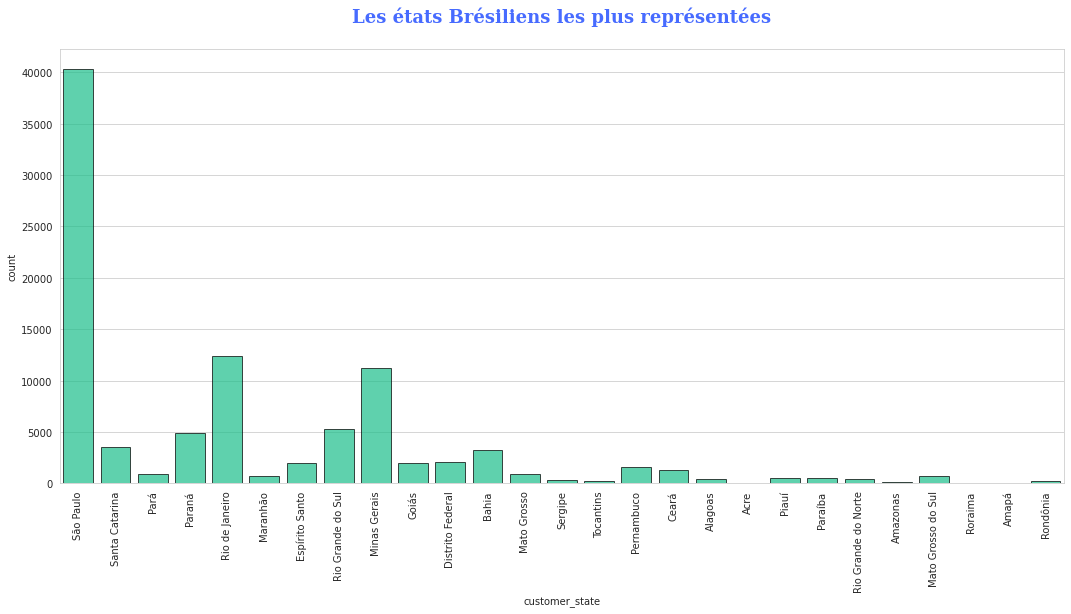

In [ ]:
# Countplot of states repartition
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data, x="customer_state",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.xticks(range(0, data["customer_state"].nunique()),
           data["customer_state"].unique(),
           rotation=90)
plt.title(f"Les états Brésiliens les plus représentées\n",
          fontdict=font_title)
plt.show()

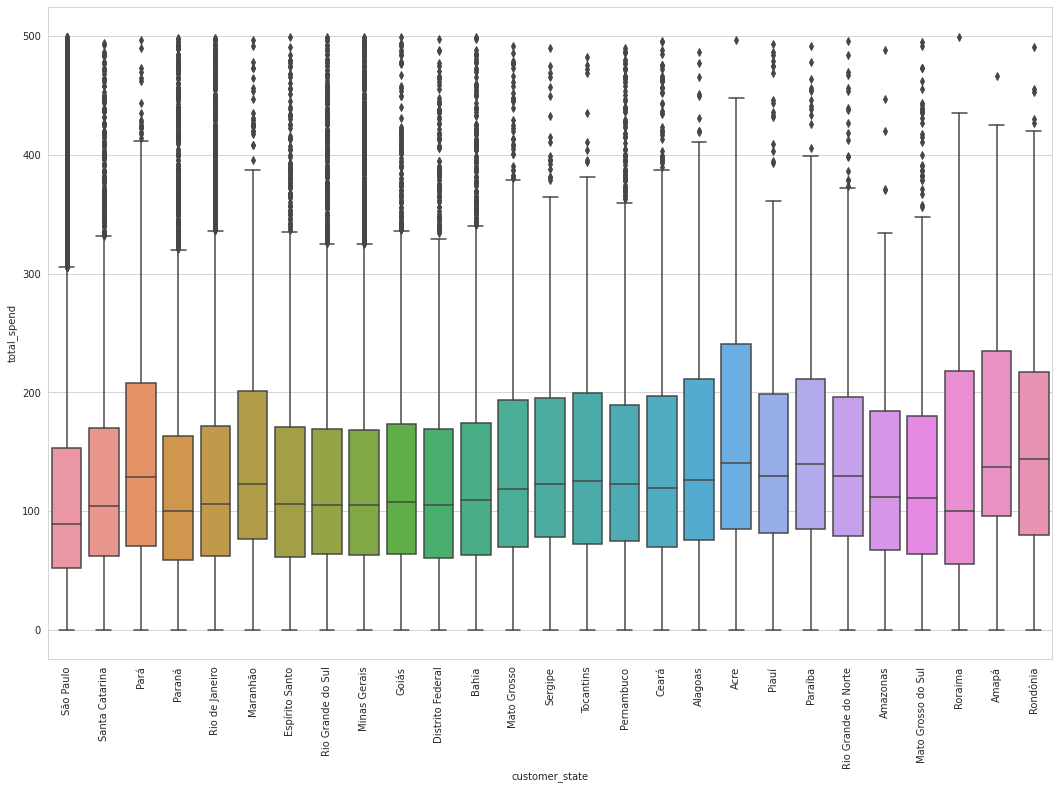

In [ ]:
# Boxplots of total spend by state
fig = plt.figure(figsize=(18,12))
sns.boxplot(x="customer_state", y="total_spend",
            data=data[data["total_spend"]<500])
plt.xticks(rotation=90)
plt.show()

On voit dans ces boxplots que l'état du client a un impact faible sur les variances et médianes des dépenses sur le site

Afin d'utiliser une variable de localisation encodable sans impact négatif sur nos modélisation, nous allons calculer la distance Haversine entre l'état du client (moyenne des latitudes et longitudes de l'état) et le siège de Olist :

In [ ]:
state_location = geolocations.groupby("geolocation_state").mean()
state_location = pd.merge(states_table[["Flag and name"]].reset_index(),
                          state_location,
                          right_on="geolocation_state",
                          left_on="Code",
                          how="left")
state_location = state_location[["Flag and name", "geolocation_lat", "geolocation_lng"]]

# Olist location
olist_lat = -25.43045
olist_lon = -49.29207

In [ ]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles

    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])

    # Formule Haversine
    dlng = lng2 - lng1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))

    return d

In [ ]:
# Haversine distance between centre state and Olist office
state_location['harvesine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y)
                              for x, y in zip(state_location.geolocation_lat,
                                              state_location.geolocation_lng)]

In [ ]:
data = pd.merge(data, state_location[["Flag and name", "harvesine_distance"]],
         how="left",
         left_on="customer_state",
         right_on="Flag and name")
data.drop("index", axis=1, inplace=True)
data.set_index("customer_unique_id", inplace=True)
data.head(3)

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,f_score,m_score,freight_ratio,mean_price_order,customer_id,customer_zip_code_prefix,customer_city,customer_state,Flag and name,harvesine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,1,0.0,0.0,0.0,...,1,141.90,0.08,129.9,fadbb3709178fc513abc1b2670aa1ad2,7787,cajamar,São Paulo,São Paulo,209.713834
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,1,0.0,0.0,0.0,...,1,27.19,0.30,18.9,4cb282e167ae9234755102258dd52ee8,6053,osasco,São Paulo,São Paulo,209.713834
0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,1,0.0,0.0,0.0,...,1,86.22,0.20,69.0,9b3932a6253894a02c1df9d19004239f,88115,sao jose,Santa Catarina,Santa Catarina,125.363853


**Correlations**

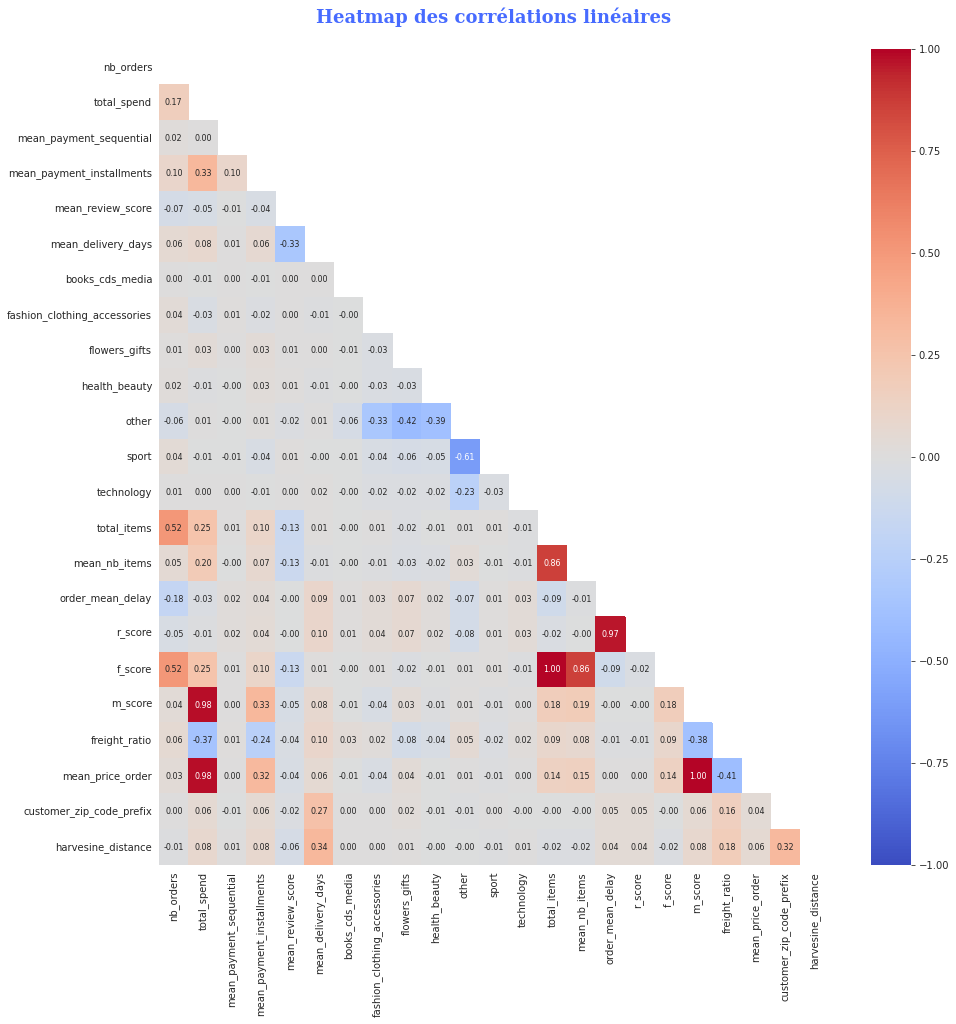

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8},
                 mask=mask,
                 center=0,
                 cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n",
          fontdict=font_title)
plt.savefig("../images/olist/heatmap.png")
plt.show()

On remarque que le prix total est très fortement corrélé au prix moyen par commande (idem pour le nombre d'articles moyen et le nombre d'articles total). Cela est dû au fait que la majorité des clients n'ont commandé qu'une seule fois.

**Dataset export**

In [ ]:
data.to_csv("olist-customers-segmentation.csv")